##### IMPORT LIBRARIES 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [7]:
import os
import shutil
import random

# Dataset path
dataset_dir = "C:/Users/mansi/lung_colon_image_set"
output_dir = "C:/Users/mansi/lungscancerproject"

# Train/Test Split Ratio
train_ratio = 0.7

# Define categories
categories = {
    "colon_image_sets": ["colon_aca", "colon_n"],
    "lung_image_sets": ["lung_aca", "lung_n"]
}

# Create output directories
for split in ["train", "test"]:
    for set_name, classes in categories.items():
        for cls in classes:
            path = os.path.join(output_dir, split, cls)
            os.makedirs(path, exist_ok=True)

# Split function
def split_data(input_dir, train_dir, test_dir):
    images = os.listdir(input_dir)
    random.shuffle(images)
    split_idx = int(len(images) * train_ratio)
    train_files = images[:split_idx]
    test_files = images[split_idx:]

    for f in train_files:
        shutil.copy(os.path.join(input_dir, f), os.path.join(train_dir, f))

    for f in test_files:
        shutil.copy(os.path.join(input_dir, f), os.path.join(test_dir, f))


# Process each class
for set_name, classes in categories.items():
    for cls in classes:
        input_path = os.path.join(dataset_dir, set_name, cls)
        train_path = os.path.join(output_dir, "train", cls)
        test_path = os.path.join(output_dir, "test", cls)

        split_data(input_path, train_path, test_path)

print("✅ Train-Test split completed! Data is in '/content/lung_colon_split/'")


✅ Train-Test split completed! Data is in '/content/lung_colon_split/'


##### DATA PREPROCESSING AND AUGMENTATION

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = "C:/Users/mansi/lungscancerproject/train"
test_dir  = "C:/Users/mansi/lungscancerproject/test"

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    shear_range=0.2,
    fill_mode="nearest"
)

# Only rescale test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

# Test/Validation generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 19964 images belonging to 4 classes.
Found 16943 images belonging to 4 classes.


#### BUILD A CNN MODEL

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [10]:
# Simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')   # 4 classes: colon_aca, colon_n, lung_aca, lung_n
])

model.summary()


c:\Users\mansi\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

#### COMPILE THE MODEL

In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


#### TRAIN THE MODEL

In [7]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20
)


c:\Users\mansi\miniconda3\envs\office\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 1233s 2s/step - accuracy: 0.7592 - loss: 0.5196 - val_accuracy: 0.7217 - val_loss: 0.4956
Epoch 2/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 976s 2s/step - accuracy: 0.8605 - loss: 0.3180 - val_accuracy: 0.9363 - val_loss: 0.1603
Epoch 3/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 970s 2s/step - accuracy: 0.9021 - loss: 0.2379 - val_accuracy: 0.9170 - val_loss: 0.1799
Epoch 4/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 924s 1s/step - accuracy: 0.9231 - loss: 0.1925 - val_accuracy: 0.9022 - val_loss: 0.2231
Epoch 5/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 878s 1s/step - accuracy: 0.9216 - loss: 0.1995 - val_accuracy: 0.9338 - val_loss: 0.1665
Epoch 6/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 880s 1s/step - accuracy: 0.9405 - loss: 0.1582 - val_accuracy: 0.9013 - val_loss: 0.2163
Epoch 7/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 878s 1s/step - accuracy: 0.9471 - loss: 0.1436 - val_accuracy: 0.9667 - val_loss: 0.0936
Epoch 8/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 881s 1s/step - accuracy: 0.9448 - loss: 0.1463 - val_acc

##### Plot accuracy & loss curves

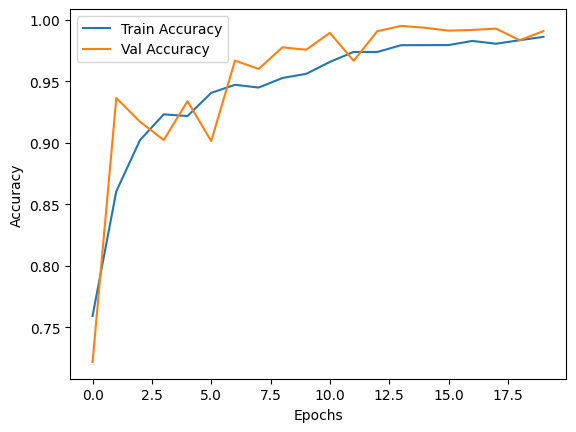

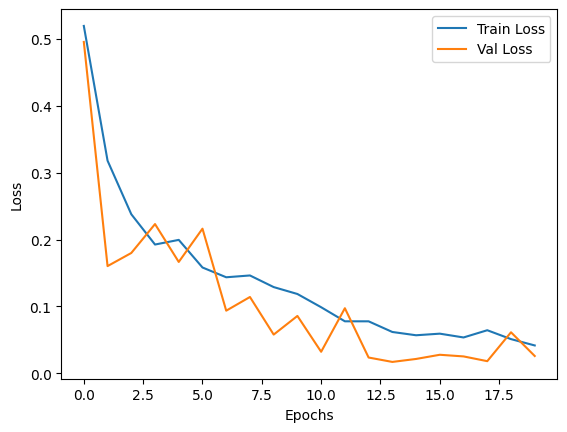

In [8]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


##### Evaluate on test data

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")


489/489 ━━━━━━━━━━━━━━━━━━━━ 152s 311ms/step - accuracy: 0.9908 - loss: 0.0258
✅ Test Accuracy: 99.08%
✅ Test Loss: 0.0258


##### Classification Report & Confusion Matrix

c:\Users\mansi\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 308s 581ms/step
Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.25      0.57      0.35      4430
     colon_n       0.00      0.00      0.00      4156
    lung_aca       0.21      0.35      0.27      4152
      lung_n       0.00      0.00      0.00      4205

    accuracy                           0.24     16943
   macro avg       0.12      0.23      0.15     16943
weighted avg       0.12      0.24      0.16     16943



c:\Users\mansi\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mansi\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mansi\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


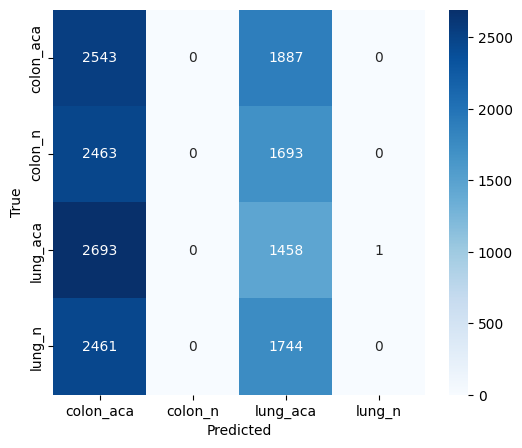

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#### test on a single image

In [12]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
model = load_model("lung_colon_cnn_model.h5")






# Load an image from your test set
img_path = "C:/Users/mansi/lungscancerproject/test/colon_aca/colonca4.jpeg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224, 224)) / 255.0
img_array = np.expand_dims(img_resized, axis=0)

# Prediction
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]

plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


NameError: name 'class_labels' is not defined

#### SAVE THE MODEL 

In [ ]:
model.save("lung_colon_cnn_model.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!


#### TO LATER LOAD THE MODEL 

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("lung_colon_cnn.keras")
